<a href="https://colab.research.google.com/github/nasr98/DOC-CNN/blob/main/CNN_DOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Document Classification

In [1]:
!pip install opencv-python
!pip install opendatasets
!pip3 install ann_visualizer
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import opendatasets as op
import cv2 as cv
import ann_visualizer as an
import graphviz as gv
import pathlib
import os
import keras

## Data Preparation

### Download Dataset

In [3]:
import shutil
op.download("https://www.kaggle.com/datasets/pdavpoojan/the-rvlcdip-dataset-test")
# try:
#   shutil.rmtree("/content/the-rvlcdip-dataset-test/test/scientific_publication")
# except FileNotFoundError:
#   print('Skip')

Skipping, found downloaded files in "./the-rvlcdip-dataset-test" (use force=True to force download)


In [4]:
cv.imread('the-rvlcdip-dataset-test/test/advertisement/00001014.tif').shape


(1000, 754, 3)


### Prepare Tensor Dataset

In [5]:
data_dir = 'the-rvlcdip-dataset-test/test'

def create_dataset(path,h,w):
  dir_list = [x for x in os.listdir(path)]
  dir_enum = {x:dir_list.index(x)+1 for x in dir_list}
  print(dir_enum)
  master = []
  label = []
  for x in dir_list:
    try:
      print(x)
      spec_path = path+'/'+x
      #Setting image size to 32,32, color to grey and normalize pixels
      img = [tf.image.resize(cv.imread(spec_path + '/' +y), tf.constant([h, w]))/255.0 for y in os.listdir(spec_path) if np.shape(cv.imread(spec_path + '/' +y)) != ()]
      labels = [dir_enum[x] for y in img]
      #extend master list with images and labels
      master.extend(img)
      label.extend(labels)
      del img
      del labels
    except TypeError:
      print(x)
  #Organize data in df
  t_df = pd.DataFrame(list(zip(label,master)),columns=['label','image'])
  #Convert DF to DS
  # t_ds = tf.data.Dataset.from_tensor_slices((list(t_df['image'].values), t_df['label'].values))
  return t_df,dir_enum

In [6]:
if os.path.exists("./rvlcdip.pkl"):
  df = pd.read_pickle("./rvlcdip.pkl")
else:
  df,dir_enum = create_dataset(data_dir,32,32)
  df.to_pickle("./rvlcdip.pkl")

In [7]:
df['image'][0].shape

TensorShape([32, 32, 3])

In [8]:
ds = tf.data.Dataset.from_tensors((list(df['image'].values), df['label'].values))
ds

<TensorDataset element_spec=(TensorSpec(shape=(39996, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(39996,), dtype=tf.int64, name=None))>

## EDA

### Sample Images

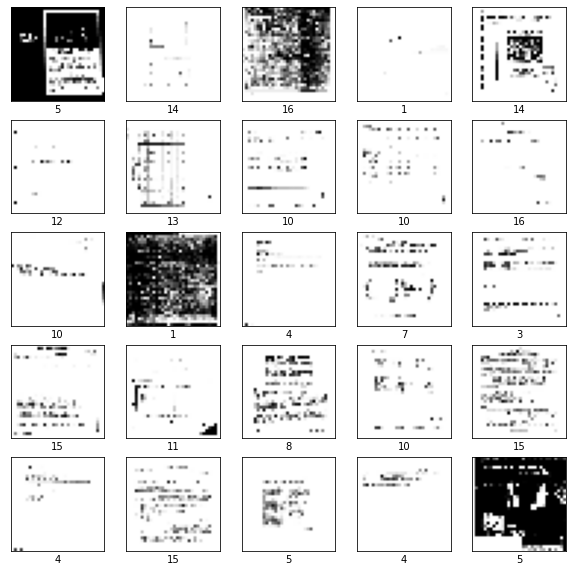

In [9]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

plt.figure(figsize=(10,10))
df1 = df.sample(frac=1).reset_index(drop=True)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(df1['image'][i])
    plt.xlabel(df1['label'][i])


### Images by label

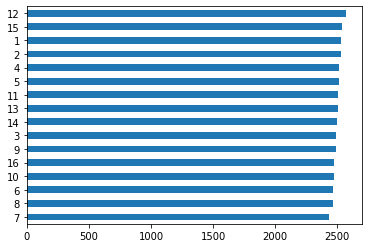

In [10]:
df['label'].value_counts().sort_values().plot(kind = 'barh',)

## Architecture Definition

### Convolution Base

In [22]:
df['image'][0].shape

TensorShape([32, 32, 3])

Edit: added dropout

In [23]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3))) # input layer

#hidden layer#
model.add(tf.keras.layers.MaxPooling2D((2, 2))) 
model.add(tf.keras.layers.Dropout(0.2)) 
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))
#############

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu')) # output layer

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)         

### Dense Layers

In [24]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(17))

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)         

### Architecture Viz

In [26]:
from ann_visualizer.visualize import ann_viz
ann_viz(model, view=True, title="DOC CNN", filename='./doccnn.gv')

## Training: Base Scoring

#### Splitting into Train,Test,Val

In [27]:
trainset = ds.shard(2, 0)
testset = ds.shard(2, 1)

#### Compilation/Training

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],run_eagerly=True,)

Edit: increased epochs from 50 to 200

In [29]:
tf.config.run_functions_eagerly(True)
# train_Y, train_X = tuple(zip(*train))
history = model.fit(trainset,epochs=200,validation_data=testset)

Epoch 1/200
1/1 [==============================] - 10s 10s/step - loss: 2.8305 - accuracy: 0.0635
Epoch 2/200
1/1 [==============================] - 10s 10s/step - loss: 2.8108 - accuracy: 0.0625
Epoch 3/200
1/1 [==============================] - 9s 9s/step - loss: 2.7926 - accuracy: 0.0668
Epoch 4/200
1/1 [==============================] - 9s 9s/step - loss: 2.7762 - accuracy: 0.0893
Epoch 5/200
1/1 [==============================] - 9s 9s/step - loss: 2.7625 - accuracy: 0.0790
Epoch 6/200
1/1 [==============================] - 9s 9s/step - loss: 2.7449 - accuracy: 0.0990
Epoch 7/200
1/1 [==============================] - 9s 9s/step - loss: 2.7248 - accuracy: 0.1142
Epoch 8/200
1/1 [==============================] - 9s 9s/step - loss: 2.7002 - accuracy: 0.1071
Epoch 9/200
1/1 [==============================] - 9s 9s/step - loss: 2.6698 - accuracy: 0.1145
Epoch 10/200
1/1 [==============================] - 9s 9s/step - loss: 2.6457 - accuracy: 0.1286
Epoch 11/200
1/1 [=================

Accuracy

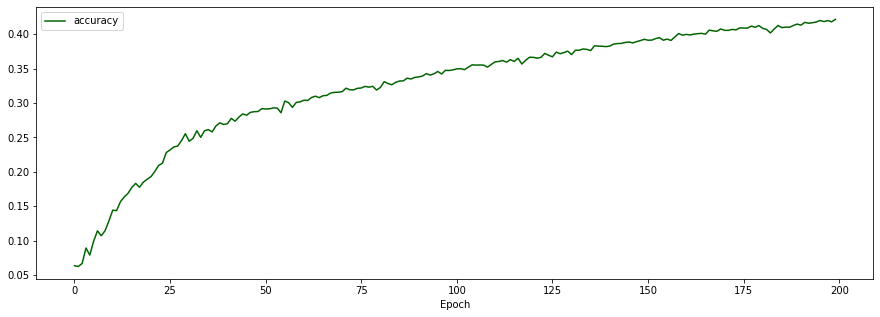

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 5))
plt.plot(history.history['accuracy'], "darkgreen", label= "accuracy")
plt.xlabel('Epoch')
plt.legend()

Loss

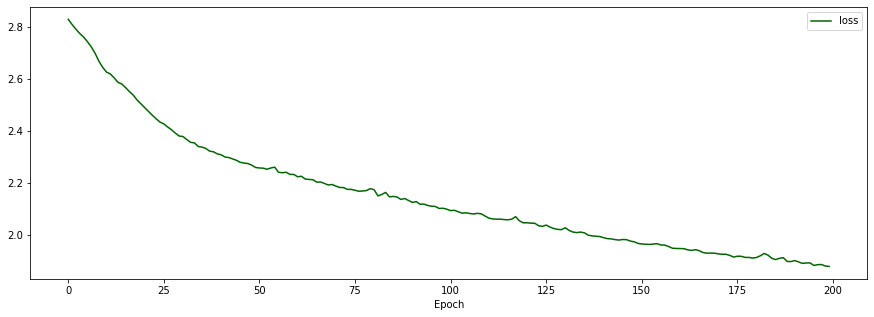

In [31]:
plt.figure(figsize = (15, 5))
plt.plot(history.history['loss'], "darkgreen", label= "loss")
plt.xlabel('Epoch')
plt.legend()

## Training: Improvements

In [4]:
cv.imread('the-rvlcdip-dataset-test/test/advertisement/00001014.tif').shape

(1000, 754, 3)

#### Resizing Images

In [4]:
if os.path.exists("./rvlcdip2.pkl"):
  df = pd.read_pickle("./rvlcdip2.pkl")
else:
  df,dir_enum = create_dataset(data_dir,128,128)
  df.to_pickle("./rvlcdip2.pkl")
ds = tf.data.Dataset.from_tensors((list(df['image'].values), df['label'].values))
ds

<TensorDataset element_spec=(TensorSpec(shape=(39996, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(39996,), dtype=tf.int64, name=None))>

In [5]:
def image_patcher(image):
    img = tf.image.resize(image, [120, 120])
    # img = cv.cvtColor(img.numpy(), cv.COLOR_BGR2GRAY)
    img1 = img[0:30, 0:120]
    img2 = img[30:90, 0:60]
    img3 = img[30:90, 60:120]
    img4 = img[90:120, 0:120]
    img = np.asarray([tf.image.resize(img1, [48, 48]),
                  tf.image.resize(img2, [48, 48]),
                  tf.image.resize(img3, [48, 48]),
                  tf.image.resize(img4, [48, 48])])
    tensor = tf.convert_to_tensor(img)
    return tensor


In [6]:
df['image'] = df['image'].apply(lambda x: image_patcher(x))

In [7]:
df['image'][0].shape

TensorShape([4, 48, 48, 3])

#### Improving Split

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['image'], df['label'], test_size=0.30, random_state=42)

train_ds = tf.data.Dataset.from_tensors((list(X_train.values), y_train.values))
test_ds = tf.data.Dataset.from_tensors((list(X_test.values), y_test.values))

In [42]:
# train_ds = train_ds.shuffle(1000)
# test_ds = test_ds.shuffle(1000)

In [43]:
# def rem_count(t):
#   for x,y in t:
#     return tf.shape(tf.squeeze(x, [0]))

In [44]:
# train_ds = train_ds.apply(rem_count)
# test_ds = test_ds.apply(rem_count)

In [45]:
for x,y in train_ds:
  print(x.shape)

(27997, 4, 48, 48, 3)


Adding validation set

#### Improving architecture

Added dropout layers to hidden layers 

In [48]:
input_shape = (4, 48, 48, 3)


model2 = tf.keras.models.Sequential()

model2.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),input_shape=input_shape)) # input layer
#hidden layer#
model2.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2),data_format="channels_last")))
model2.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))
model2.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (3, 3), activation='relu',data_format="channels_last")))
model2.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2),data_format="channels_last")))
model2.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))
#############
model2.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (3, 3), activation='relu',data_format="channels_last"))) # output layer
model2.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
##Dense layers##
# model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.GlobalAveragePooling1D())
model2.add(tf.keras.layers.Dense(64, activation='relu'))
model2.add(tf.keras.layers.Dense(17))
#############

model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 4, 46, 46, 32)    896       
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 4, 23, 23, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 4, 23, 23, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 4, 21, 21, 64)    18496     
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 4, 10, 10, 64)   

In [49]:
# ann_viz(model, view=True, title="DOC CNN v2", filename='./doccnn2.gv')

#### Implementing Learning Rate Scheduler & Early Stopping

In [50]:
from keras.callbacks import EarlyStopping
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
earlyStopping = EarlyStopping(monitor = 'loss', patience = 10, mode = 'min', restore_best_weights = True)

#### Train Stage

In [51]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],run_eagerly=True,)

In [ ]:
#Increased Epochs to 100
tf.config.run_functions_eagerly(True)
history = model2.fit(train_ds, epochs=50,callbacks=[callback,earlyStopping],validation_data=test_ds)

Epoch 1/50


Accuracy

In [ ]:

plt.figure(figsize = (15, 5))
plt.plot(history.history['accuracy'], "darkgreen", label= "accuracy")
plt.xlabel('Epoch')
plt.legend()


Loss

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(history.history['loss'], "darkgreen", label= "loss")
plt.xlabel('Epoch')
plt.legend()